In [1]:
import os
import math
import numbers
import random
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            mask = Image.fromarray(mask, mode="RGB")
            self.PIL2Numpy = True

        assert img.size == mask.size
        for a in self.augmentations:
            img, mask = a(img, mask)

        if self.PIL2Numpy:
            img, mask = np.array(img), np.array(mask, dtype=np.uint8)

        return img, mask

class RandomHorizontallyFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT))
        return img, mask
        
class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size
        w, h = img.size
        ch, cw = self.size
        if w == cw and h == ch:
            return img, mask
        if w < cw or h < ch:
            pw = cw - w if cw > w else 0
            ph = ch - h if ch > h else 0
            padding = (pw,ph,pw,ph)
            img  = ImageOps.expand(img,  padding, fill=0)
            mask = ImageOps.expand(mask, padding, fill=250)
            w, h = img.size
            assert img.size == mask.size
            
        x1 = random.randint(0, w - cw)
        y1 = random.randint(0, h - ch)
        return (img.crop((x1, y1, x1 + cw, y1 + ch)), mask.crop((x1, y1, x1 + cw, y1 + ch)))


In [2]:
from traitlets.traitlets import Long
#data loader
import collections
import torch
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
import skimage.transform
from torch.utils import data


def rgb_to_lbl(rgb, size):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]
#     Unlabelled = [0, 0, 0]

    label_colours = np.array(
        [
            Sky,
            Building,
            Pole,
            Road,
            Pavement,
            Tree,
            SignSymbol,
            Fence,
            Car,
            Pedestrian,
            Bicyclist,
#             Unlabelled,
        ]
    )
    label = 11 * torch.ones(size[0] * size[1], dtype=torch.uint8)
    w, h, t = rgb.size()
    rgb = rgb.reshape(-1, t)
    for l in range(0, len(label_colours)):
      r = rgb[:, 0] == label_colours[l, 0]
      g = rgb[:, 1] == label_colours[l, 1]
      b = rgb[:, 2] == label_colours[l, 2]
      tf_rgb = r * g * b
      label[tf_rgb] = l
    label = label.reshape(size[0], size[1])
    #print(rgb2[360][260:270], label[360][260:270])
    return label

class camvidLoader(data.Dataset):
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=None,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.split = split
        self.img_size = img_size if img_size is not None else [360, 480];
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 11
        self.files = collections.defaultdict(list)

        if not self.test_mode:
            for split in ["train", "test", "val"]:
                file_list = os.listdir(root + "/" + split)
                self.files[split] = file_list

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_name = self.files[self.split][index]
        img_path = self.root + "/" + self.split + "/" + img_name
        lbl_path = self.root + "/" + self.split + "_labels/" + img_name.split('.')[0] + '_L.' + img_name.split('.')[1]

        img = plt.imread(img_path)
        img = np.array(img*255, dtype=np.uint8)

        lbl = plt.imread(lbl_path)
        lbl = np.array(lbl*255, dtype=np.uint8)

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
#         print(img.shape, lbl.shape)
        img = skimage.transform.resize(img, (self.img_size[0], self.img_size[1]), preserve_range=True)  # uint8 with RGB mode
        lbl = skimage.transform.resize(lbl, (self.img_size[0], self.img_size[1]), anti_aliasing=False, preserve_range=True)
#         print(img.shape, lbl.shape)
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        img = torch.from_numpy(img).float()
        return img, lbl

    def decode_segmap(self, temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road = [128, 64, 128]
        Pavement = [60, 40, 222]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]
        # Unlabelled = [0, 0, 0]

        label_colours = np.array(
            [
                Sky,
                Building,
                Pole,
                Road,
                Pavement,
                Tree,
                SignSymbol,
                Fence,
                Car,
                Pedestrian,
                Bicyclist,
                # Unlabelled,
            ]
        )
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

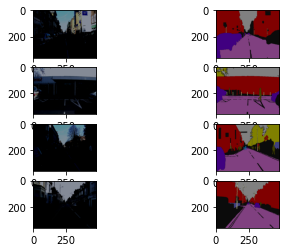

 ex


In [3]:
#testing data loader
local_path = "../input/camvid/CamVid"
augmentations = Compose([RandomHorizontallyFlip(0.5), 
                         #RandomCrop(270, 360)
                         ])

dst = camvidLoader(local_path, is_transform=True, augmentations=augmentations)
bs = 4
trainloader = data.DataLoader(dst, batch_size=bs, shuffle=True)
for i, data_samples in enumerate(trainloader):
    imgs, labels = data_samples
    # print(imgs.size())
    imgs = imgs.numpy()[:, ::-1, :, :]
    imgs = np.transpose(imgs, [0, 2, 3, 1])
    newlabels=torch.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
    # print(type(labels))
    for i in range(len(labels)):
      #print(labels[i,:,:,:].shape)
      # print(labels[i, :, :, :].size(), imgs.shape)
      newlabels[i] = rgb_to_lbl(labels[i,:,:,:], [labels.shape[1], labels.shape[2]])
    labels = newlabels
    f, axarr = plt.subplots(bs, 2)
    for j in range(bs):
        axarr[j][0].imshow(imgs[j])
        axarr[j][1].imshow(dst.decode_segmap(newlabels.numpy()[j]))
    plt.show()
    a = input()
    if a == "ex":
        break
    else:
        plt.close()

In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import collections
#from CatConv2d.catconv2d import CatConv2d

class ConvLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, dropout=0.1):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel,
                                          stride=stride, padding=kernel//2, bias = False))
        self.add_module('norm', nn.BatchNorm2d(out_channels))
        self.add_module('relu', nn.ReLU(inplace=True))

        #print(kernel, 'x', kernel, 'x', in_channels, 'x', out_channels)

    def forward(self, x):
        return super().forward(x)
        

class BRLayer(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
    def forward(self, x):
        return super().forward(x)


class HarDBlock_v2(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link


    def get_out_ch(self):
        return self.out_channels

    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False, dwconv=False, list_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        self.list_out = list_out
        layers_ = []
        self.out_channels = 0

        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          #layers_.append(CatConv2d(inch, outch, (3,3), relu=True))
          layers_.append(nn.Conv2d(inch, outch, (3,3), relu=True))

          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)

    def transform(self, blk):
        for i in range(len(self.layers)):
            self.layers[i].weight[:,:,:,:] = blk.layers[i][0].weight[:,:,:,:]
            self.layers[i].bias[:] = blk.layers[i][0].bias[:]

    def forward(self, x):
        layers_ = [x]
        #self.res = []
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])

            out = self.layers[layer](tin)
            #self.res.append(out)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        if self.list_out:
            return out_
        else:
            return torch.cat(out_, 1)



class HarDBlock(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link

    def get_out_ch(self):
        return self.out_channels
 
    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        layers_ = []
        self.out_channels = 0 # if upsample else in_channels
        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          layers_.append(ConvLayer(inch, outch))
          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        #print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)


    def forward(self, x):
        layers_ = [x]
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])
            if len(tin) > 1:
                x = torch.cat(tin, 1)
            else:
                x = tin[0]
            out = self.layers[layer](x)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        out = torch.cat(out_, 1)
        return out



class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #print("upsample",in_channels, out_channels)

    def forward(self, x, skip, concat=True):
        is_v2 = type(skip) is list
        if is_v2:
            skip_x = skip[0]
        else:
            skip_x = skip
        out = F.interpolate(
                x,
                size=(skip_x.size(2), skip_x.size(3)),
                mode="bilinear",
                align_corners=True,
                            )
        if concat:       
          if is_v2:
            out = [out] + skip
          else:                     
            out = torch.cat([out, skip], 1)
          
        return out

class hardnet(nn.Module):
    def __init__(self, n_classes=11):
        super(hardnet, self).__init__()

        first_ch  = [16,24,32,48]
        ch_list = [  64, 96, 160, 224, 320]
        grmul = 1.7
        gr       = [  10,16,18,24,32]
        n_layers = [   4, 4, 8, 8, 8]

        blks = len(n_layers) 
        self.shortcut_layers = []

        self.base = nn.ModuleList([])
        self.base.append (
             ConvLayer(in_channels=3, out_channels=first_ch[0], kernel=3,
                       stride=2) )
        self.base.append ( ConvLayer(first_ch[0], first_ch[1],  kernel=3) )
        self.base.append ( ConvLayer(first_ch[1], first_ch[2],  kernel=3, stride=2) )
        self.base.append ( ConvLayer(first_ch[2], first_ch[3],  kernel=3) )

        skip_connection_channel_counts = []
        ch = first_ch[3]
        for i in range(blks):
            blk = HarDBlock(ch, gr[i], grmul, n_layers[i])
            ch = blk.get_out_ch()
            skip_connection_channel_counts.append(ch)
            self.base.append ( blk )
            if i < blks-1:
              self.shortcut_layers.append(len(self.base)-1)

            self.base.append ( ConvLayer(ch, ch_list[i], kernel=1) )
            ch = ch_list[i]
            
            if i < blks-1:            
              self.base.append ( nn.AvgPool2d(kernel_size=2, stride=2) )


        cur_channels_count = ch
        prev_block_channels = ch
        n_blocks = blks-1
        self.n_blocks =  n_blocks

        # upsampling

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        self.conv1x1_up    = nn.ModuleList([])
        
        for i in range(n_blocks-1,-1,-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]
            self.conv1x1_up.append(ConvLayer(cur_channels_count, cur_channels_count//2, kernel=1))
            cur_channels_count = cur_channels_count//2

            blk = HarDBlock(cur_channels_count, gr[i], grmul, n_layers[i])
            
            self.denseBlocksUp.append(blk)
            prev_block_channels = blk.get_out_ch()
            cur_channels_count = prev_block_channels


        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
               padding=0, bias=True)
    
    def v2_transform(self):        
        for i in range( len(self.base)):
            if isinstance(self.base[i], HarDBlock):
                blk = self.base[i]
                self.base[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=True)
                self.base[i].transform(blk)
            elif isinstance(self.base[i], nn.Sequential):
                blk = self.base[i]
                sz = blk[0].weight.shape
                if sz[2] == 1:
                    #self.base[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                    self.base[i].bias[:] = blk[0].bias[:]

        for i in range(self.n_blocks):
            blk = self.denseBlocksUp[i]
            self.denseBlocksUp[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=False)
            self.denseBlocksUp[i].transform(blk)
  
        for i in range(len(self.conv1x1_up)):
            blk = self.conv1x1_up[i]
            sz = blk[0].weight.shape
            if sz[2] == 1:
                #self.conv1x1_up[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                self.conv1x1_up[i].bias[:] = blk[0].bias[:]                 

    def forward(self, x):
        
        skip_connections = []
        size_in = x.size()
        
        
        for i in range(len(self.base)):
            x = self.base[i](x)
            if i in self.shortcut_layers:
                skip_connections.append(x)
        out = x
        
        for i in range(self.n_blocks):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip, True)
            out = self.conv1x1_up[i](out)
            out = self.denseBlocksUp[i](out)
        
        out = self.finalConv(out)
        
        out = F.interpolate(
                            out,
                            size=(size_in[2], size_in[3]),
                            mode="bilinear",
                            align_corners=True)
        return out

In [5]:
class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return (
            {
                "Overall Acc: \t": acc,
                "Mean Acc : \t": acc_cls,
                "FreqW Acc : \t": fwavacc,
                "Mean IoU : \t": mean_iu,
            },
            cls_iu,
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))


class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [6]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()
    #print(input.size(), target.size())
    #nt, ht, wt = target.size()

    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    #print(input.size(), target.size())
    #print(input[0, 0].dtype, target[0].dtype)
    loss = F.cross_entropy(
              input, target, weight=weight, size_average=size_average, ignore_index=11, reduction='mean')

    return loss


In [9]:
import time
from tqdm import tqdm

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)


# Setup seeds
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup Augmentations
data_aug = Compose([RandomHorizontallyFlip(0.5), 
                    # RandomCrop((270, 360))
                    ])

# Setup Dataloader

data_loader = camvidLoader
data_path = '../input/camvid/CamVid'

t_loader = data_loader(
    data_path,
    is_transform=True,
    split='train',
    img_size=(720, 960),
    augmentations=data_aug,
)

v_loader = data_loader(
    data_path,
    is_transform=True,
    split='val',
    img_size=(720, 960),
)

n_classes = t_loader.n_classes
trainloader = data.DataLoader(
    t_loader,
    batch_size=16,
    shuffle=True,
)

valloader = data.DataLoader(
    v_loader, 
    batch_size=16, 
)

# Setup Metrics
running_metrics_val = runningScore(n_classes)

# Setup Model

model = hardnet()

total_params = sum(p.numel() for p in model.parameters())
print( 'Parameters:',total_params )

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.apply(weights_init)
optimizer_cls = torch.optim.Adam

optimizer = optimizer_cls(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=2.5e-5)
print("Using optimizer {}".format(optimizer))

num_epochs = 50
per_epoch = len(trainloader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

loss_fn = cross_entropy2d
print("Using loss {}".format(loss_fn))

start_epoch = 0
resume = None
file_checkpoint = 'hardnet_CamVid_checkpoint.pkl'
if resume is not None:
    if os.path.isfile(file_checkpoint):
        print("Loading model and optimizer from checkpoint '{}'".format(file_checkpoint))
              
        checkpoint = torch.load(file_checkpoint)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        start_epoch = checkpoint["epoch"] + 1

    else:
        print("No checkpoint found at '{}'".format(file_checkpoint))

val_loss_meter = averageMeter()
time_meter = averageMeter()

best_iou = -100.0
flag = True
loss_all = 0
loss_n = 0
for epoch in range(start_epoch, num_epochs):
    curr_iter = 0
    for (images, labels) in trainloader:
        start_ts = time.time()
        curr_iter += 1
        model.train()
        images = images.to(device)
        newlabels = torch.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
        for j in range(len(labels)):
          newlabels[j] = rgb_to_lbl(labels[j, :, :, :], [labels.shape[1], labels.shape[2]])
        labels = newlabels
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(input=outputs, target=labels.long())
        loss.backward()
        optimizer.step()
        c_lr = scheduler.get_last_lr()

        time_meter.update(time.time() - start_ts)
        loss_all += loss.item()
        loss_n += 1
                
        if curr_iter % 6 == 0:
            fmt_str = "Epoch {:d} Batch [{:d}/{:d}]  Loss: {:.4f}  Time/Image: {:.4f}  lr={:.6f}"
            print_str = fmt_str.format(
                epoch,
                curr_iter,
                per_epoch,
                loss_all / loss_n,
                time_meter.avg / 16,
                c_lr[0],
            )
            

            print(print_str)
            time_meter.reset()

    scheduler.step() 
    torch.cuda.empty_cache()
    model.eval()
    loss_all = 0
    loss_n = 0
    with torch.no_grad():
        for i_val, (images_val, labels_val) in tqdm(enumerate(valloader)):
            images_val = images_val.to(device)
            newlabels = torch.zeros((labels_val.shape[0], labels_val.shape[1], labels_val.shape[2]))
            for j in range(len(labels_val)):
              newlabels[j] = rgb_to_lbl(labels_val[j, :, :, :], [labels_val.shape[1], labels_val.shape[2]])
            labels_val = newlabels
            labels_val = labels_val.to(device)

            outputs = model(images_val)
            val_loss = loss_fn(input=outputs, target=labels_val.long())

            pred = outputs.data.max(1)[1].cpu().numpy()
            gt = labels_val.data.cpu().numpy()

            running_metrics_val.update(gt, pred)
            val_loss_meter.update(val_loss.item())

    print(format("Epoch %d Iter %d Val Loss: %.4f" % (epoch, curr_iter + 1, val_loss_meter.avg)))

    score, class_iou = running_metrics_val.get_scores()
    for k, v in score.items():
        print(k, v)

    val_loss_meter.reset()
    running_metrics_val.reset()
    
    state = {
          "epoch": epoch,
          "model_state": model.state_dict(),
          "optimizer_state": optimizer.state_dict(),
          "scheduler_state": scheduler.state_dict(),
    }
    save_path = os.path.join(
        './',
        "{}_{}_checkpoint.pkl".format('hardnet', 'CamVid'),
    )
    torch.save(state, save_path)

    torch.cuda.empty_cache()

  

Parameters: 4118865
Using optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 2.5e-05
)
Using loss <function cross_entropy2d at 0x7f36159d7a70>
Epoch 0 Batch [6/24]  Loss: 1.7735  Time/Image: 0.1263  lr=0.001000
Epoch 0 Batch [12/24]  Loss: 1.3699  Time/Image: 0.1210  lr=0.001000
Epoch 0 Batch [18/24]  Loss: 1.1675  Time/Image: 0.1182  lr=0.001000
Epoch 0 Batch [24/24]  Loss: 1.0347  Time/Image: 0.0987  lr=0.001000


7it [00:44,  6.42s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Epoch 0 Iter 25 Val Loss: 2.8040
Overall Acc: 	 0.586126845811491
Mean Acc : 	 0.19177791752274187
FreqW Acc : 	 0.39218117904400535
Mean IoU : 	 0.12352831199840268
Epoch 1 Batch [6/24]  Loss: 0.5911  Time/Image: 0.1164  lr=0.001000
Epoch 1 Batch [12/24]  Loss: 0.5595  Time/Image: 0.1176  lr=0.001000
Epoch 1 Batch [18/24]  Loss: 0.5468  Time/Image: 0.1176  lr=0.001000
Epoch 1 Batch [24/24]  Loss: 0.5955  Time/Image: 0.0977  lr=0.001000


7it [00:44,  6.39s/it]


Epoch 1 Iter 25 Val Loss: 0.9195
Overall Acc: 	 0.7602332008217978
Mean Acc : 	 0.2910002778701652
FreqW Acc : 	 0.6270074774801948
Mean IoU : 	 0.23987020610465914
Epoch 2 Batch [6/24]  Loss: 0.6434  Time/Image: 0.1151  lr=0.000999
Epoch 2 Batch [12/24]  Loss: 0.5901  Time/Image: 0.1175  lr=0.000999
Epoch 2 Batch [18/24]  Loss: 0.5523  Time/Image: 0.1165  lr=0.000999
Epoch 2 Batch [24/24]  Loss: 0.5369  Time/Image: 0.1035  lr=0.000999


7it [00:44,  6.35s/it]


Epoch 2 Iter 25 Val Loss: 0.4794
Overall Acc: 	 0.8642697133290332
Mean Acc : 	 0.438876412486146
FreqW Acc : 	 0.7770616640464891
Mean IoU : 	 0.3654713940625084
Epoch 3 Batch [6/24]  Loss: 0.4458  Time/Image: 0.1131  lr=0.000998
Epoch 3 Batch [12/24]  Loss: 0.4336  Time/Image: 0.1158  lr=0.000998
Epoch 3 Batch [18/24]  Loss: 0.4255  Time/Image: 0.1187  lr=0.000998
Epoch 3 Batch [24/24]  Loss: 0.4243  Time/Image: 0.0970  lr=0.000998


7it [00:44,  6.34s/it]


Epoch 3 Iter 25 Val Loss: 0.3896
Overall Acc: 	 0.8871674316411076
Mean Acc : 	 0.5120164525266693
FreqW Acc : 	 0.8142282541735626
Mean IoU : 	 0.4161907784286588
Epoch 4 Batch [6/24]  Loss: 0.3846  Time/Image: 0.1172  lr=0.000996
Epoch 4 Batch [12/24]  Loss: 0.3833  Time/Image: 0.1138  lr=0.000996
Epoch 4 Batch [18/24]  Loss: 0.3680  Time/Image: 0.1143  lr=0.000996
Epoch 4 Batch [24/24]  Loss: 0.3708  Time/Image: 0.1041  lr=0.000996


7it [00:44,  6.35s/it]


Epoch 4 Iter 25 Val Loss: 0.3055
Overall Acc: 	 0.91718032755889
Mean Acc : 	 0.5177767082972873
FreqW Acc : 	 0.852577840861716
Mean IoU : 	 0.45337438947233916
Epoch 5 Batch [6/24]  Loss: 0.3338  Time/Image: 0.1164  lr=0.000994
Epoch 5 Batch [12/24]  Loss: 0.3413  Time/Image: 0.1169  lr=0.000994
Epoch 5 Batch [18/24]  Loss: 0.3440  Time/Image: 0.1147  lr=0.000994
Epoch 5 Batch [24/24]  Loss: 0.3626  Time/Image: 0.0975  lr=0.000994


7it [00:44,  6.29s/it]


Epoch 5 Iter 25 Val Loss: 0.3579
Overall Acc: 	 0.8957421641507237
Mean Acc : 	 0.47550340127491786
FreqW Acc : 	 0.8177443436828689
Mean IoU : 	 0.42384543045515943
Epoch 6 Batch [6/24]  Loss: 0.3481  Time/Image: 0.1195  lr=0.000991
Epoch 6 Batch [12/24]  Loss: 0.3310  Time/Image: 0.1145  lr=0.000991
Epoch 6 Batch [18/24]  Loss: 0.3141  Time/Image: 0.1212  lr=0.000991
Epoch 6 Batch [24/24]  Loss: 0.3100  Time/Image: 0.0997  lr=0.000991


7it [00:44,  6.43s/it]


Epoch 6 Iter 25 Val Loss: 0.3412
Overall Acc: 	 0.8982752472720257
Mean Acc : 	 0.5381750266793632
FreqW Acc : 	 0.8227498764140605
Mean IoU : 	 0.46566332836585617
Epoch 7 Batch [6/24]  Loss: 0.2860  Time/Image: 0.1206  lr=0.000988
Epoch 7 Batch [12/24]  Loss: 0.2883  Time/Image: 0.1155  lr=0.000988
Epoch 7 Batch [18/24]  Loss: 0.2737  Time/Image: 0.1169  lr=0.000988
Epoch 7 Batch [24/24]  Loss: 0.2869  Time/Image: 0.0976  lr=0.000988


7it [00:44,  6.41s/it]


Epoch 7 Iter 25 Val Loss: 1.1501
Overall Acc: 	 0.7641382961488862
Mean Acc : 	 0.4896999013124691
FreqW Acc : 	 0.6310334233643271
Mean IoU : 	 0.37313644761379294
Epoch 8 Batch [6/24]  Loss: 0.4185  Time/Image: 0.1150  lr=0.000984
Epoch 8 Batch [12/24]  Loss: 0.3751  Time/Image: 0.1206  lr=0.000984
Epoch 8 Batch [18/24]  Loss: 0.3607  Time/Image: 0.1141  lr=0.000984
Epoch 8 Batch [24/24]  Loss: 0.3521  Time/Image: 0.0968  lr=0.000984


7it [00:44,  6.39s/it]


Epoch 8 Iter 25 Val Loss: 0.3559
Overall Acc: 	 0.8923898271362597
Mean Acc : 	 0.5156681778004957
FreqW Acc : 	 0.8127112263804994
Mean IoU : 	 0.4476167618093479
Epoch 9 Batch [6/24]  Loss: 0.3295  Time/Image: 0.1140  lr=0.000980
Epoch 9 Batch [12/24]  Loss: 0.3277  Time/Image: 0.1189  lr=0.000980
Epoch 9 Batch [18/24]  Loss: 0.3232  Time/Image: 0.1139  lr=0.000980
Epoch 9 Batch [24/24]  Loss: 0.3299  Time/Image: 0.0983  lr=0.000980


7it [00:44,  6.37s/it]


Epoch 9 Iter 25 Val Loss: 0.4219
Overall Acc: 	 0.8554675382548098
Mean Acc : 	 0.5109183070640072
FreqW Acc : 	 0.7766059456060878
Mean IoU : 	 0.39760976934254505
Epoch 10 Batch [6/24]  Loss: 0.3930  Time/Image: 0.1193  lr=0.000976
Epoch 10 Batch [12/24]  Loss: 0.3706  Time/Image: 0.1190  lr=0.000976
Epoch 10 Batch [18/24]  Loss: 0.3558  Time/Image: 0.1167  lr=0.000976
Epoch 10 Batch [24/24]  Loss: 0.3807  Time/Image: 0.1037  lr=0.000976


7it [00:44,  6.42s/it]


Epoch 10 Iter 25 Val Loss: 0.5580
Overall Acc: 	 0.8385999871943236
Mean Acc : 	 0.3894398403762739
FreqW Acc : 	 0.7367126875104599
Mean IoU : 	 0.3417015579895256
Epoch 11 Batch [6/24]  Loss: 0.3266  Time/Image: 0.1221  lr=0.000970
Epoch 11 Batch [12/24]  Loss: 0.3208  Time/Image: 0.1174  lr=0.000970
Epoch 11 Batch [18/24]  Loss: 0.3102  Time/Image: 0.1189  lr=0.000970
Epoch 11 Batch [24/24]  Loss: 0.3189  Time/Image: 0.1006  lr=0.000970


7it [00:44,  6.33s/it]


Epoch 11 Iter 25 Val Loss: 0.4020
Overall Acc: 	 0.8457548881802317
Mean Acc : 	 0.555067806505479
FreqW Acc : 	 0.7449173807984261
Mean IoU : 	 0.4527164349361392
Epoch 12 Batch [6/24]  Loss: 0.2998  Time/Image: 0.1163  lr=0.000965
Epoch 12 Batch [12/24]  Loss: 0.2887  Time/Image: 0.1169  lr=0.000965
Epoch 12 Batch [18/24]  Loss: 0.2842  Time/Image: 0.1186  lr=0.000965
Epoch 12 Batch [24/24]  Loss: 0.2975  Time/Image: 0.1008  lr=0.000965


7it [00:44,  6.37s/it]


Epoch 12 Iter 25 Val Loss: 0.4173
Overall Acc: 	 0.8615318425176819
Mean Acc : 	 0.5203927094032856
FreqW Acc : 	 0.7863209173027572
Mean IoU : 	 0.4081385076814056
Epoch 13 Batch [6/24]  Loss: 0.2810  Time/Image: 0.1164  lr=0.000959
Epoch 13 Batch [12/24]  Loss: 0.2812  Time/Image: 0.1181  lr=0.000959
Epoch 13 Batch [18/24]  Loss: 0.2849  Time/Image: 0.1214  lr=0.000959
Epoch 13 Batch [24/24]  Loss: 0.2837  Time/Image: 0.1018  lr=0.000959


7it [00:44,  6.36s/it]


Epoch 13 Iter 25 Val Loss: 0.2771
Overall Acc: 	 0.9110791704499992
Mean Acc : 	 0.5559102285917074
FreqW Acc : 	 0.8429599379703945
Mean IoU : 	 0.5017795782586243
Epoch 14 Batch [6/24]  Loss: 0.2767  Time/Image: 0.1228  lr=0.000952
Epoch 14 Batch [12/24]  Loss: 0.2977  Time/Image: 0.1147  lr=0.000952
Epoch 14 Batch [18/24]  Loss: 0.2810  Time/Image: 0.1167  lr=0.000952
Epoch 14 Batch [24/24]  Loss: 0.2735  Time/Image: 0.0963  lr=0.000952


7it [00:44,  6.39s/it]


Epoch 14 Iter 25 Val Loss: 0.2437
Overall Acc: 	 0.9277214447381347
Mean Acc : 	 0.5928447496816892
FreqW Acc : 	 0.8696017650726823
Mean IoU : 	 0.5331820309027988
Epoch 15 Batch [6/24]  Loss: 0.2427  Time/Image: 0.1170  lr=0.000946
Epoch 15 Batch [12/24]  Loss: 0.2502  Time/Image: 0.1148  lr=0.000946
Epoch 15 Batch [18/24]  Loss: 0.2480  Time/Image: 0.1174  lr=0.000946
Epoch 15 Batch [24/24]  Loss: 0.2407  Time/Image: 0.0979  lr=0.000946


7it [00:44,  6.29s/it]


Epoch 15 Iter 25 Val Loss: 0.2591
Overall Acc: 	 0.9184958744665555
Mean Acc : 	 0.6102333228409477
FreqW Acc : 	 0.8630215418015053
Mean IoU : 	 0.5221696734802249
Epoch 16 Batch [6/24]  Loss: 0.2295  Time/Image: 0.1185  lr=0.000938
Epoch 16 Batch [12/24]  Loss: 0.2357  Time/Image: 0.1164  lr=0.000938
Epoch 16 Batch [18/24]  Loss: 0.2319  Time/Image: 0.1181  lr=0.000938
Epoch 16 Batch [24/24]  Loss: 0.2334  Time/Image: 0.0989  lr=0.000938


7it [00:44,  6.36s/it]


Epoch 16 Iter 25 Val Loss: 0.2428
Overall Acc: 	 0.9247453024008925
Mean Acc : 	 0.6232779682527054
FreqW Acc : 	 0.8668596056683749
Mean IoU : 	 0.5429226379648159
Epoch 17 Batch [6/24]  Loss: 0.2377  Time/Image: 0.1201  lr=0.000930
Epoch 17 Batch [12/24]  Loss: 0.2360  Time/Image: 0.1169  lr=0.000930
Epoch 17 Batch [18/24]  Loss: 0.2343  Time/Image: 0.1190  lr=0.000930
Epoch 17 Batch [24/24]  Loss: 0.2509  Time/Image: 0.1001  lr=0.000930


7it [00:44,  6.39s/it]


Epoch 17 Iter 25 Val Loss: 0.2172
Overall Acc: 	 0.9338688913593054
Mean Acc : 	 0.6599144576730118
FreqW Acc : 	 0.8848819288895663
Mean IoU : 	 0.5654013365614332
Epoch 18 Batch [6/24]  Loss: 0.2297  Time/Image: 0.1170  lr=0.000922
Epoch 18 Batch [12/24]  Loss: 0.2292  Time/Image: 0.1197  lr=0.000922
Epoch 18 Batch [18/24]  Loss: 0.2263  Time/Image: 0.1170  lr=0.000922
Epoch 18 Batch [24/24]  Loss: 0.2484  Time/Image: 0.1048  lr=0.000922


7it [00:44,  6.42s/it]


Epoch 18 Iter 25 Val Loss: 0.2217
Overall Acc: 	 0.9302872038203888
Mean Acc : 	 0.6323021140382774
FreqW Acc : 	 0.8748140110401617
Mean IoU : 	 0.5603493143886917
Epoch 19 Batch [6/24]  Loss: 0.2780  Time/Image: 0.1197  lr=0.000914
Epoch 19 Batch [12/24]  Loss: 0.2789  Time/Image: 0.1171  lr=0.000914
Epoch 19 Batch [18/24]  Loss: 0.2789  Time/Image: 0.1191  lr=0.000914
Epoch 19 Batch [24/24]  Loss: 0.2764  Time/Image: 0.0985  lr=0.000914


7it [00:45,  6.43s/it]


Epoch 19 Iter 25 Val Loss: 0.4660
Overall Acc: 	 0.8697202389418902
Mean Acc : 	 0.5637048368583896
FreqW Acc : 	 0.7846920714576965
Mean IoU : 	 0.4654023690653724
Epoch 20 Batch [6/24]  Loss: 0.2919  Time/Image: 0.1183  lr=0.000905
Epoch 20 Batch [12/24]  Loss: 0.2727  Time/Image: 0.1220  lr=0.000905
Epoch 20 Batch [18/24]  Loss: 0.2666  Time/Image: 0.1202  lr=0.000905
Epoch 20 Batch [24/24]  Loss: 0.2758  Time/Image: 0.1022  lr=0.000905


7it [00:44,  6.31s/it]


Epoch 20 Iter 25 Val Loss: 0.3097
Overall Acc: 	 0.9027668425799914
Mean Acc : 	 0.6097113994336134
FreqW Acc : 	 0.833300424054317
Mean IoU : 	 0.5111641849292345
Epoch 21 Batch [6/24]  Loss: 0.2426  Time/Image: 0.1179  lr=0.000895
Epoch 21 Batch [12/24]  Loss: 0.2390  Time/Image: 0.1179  lr=0.000895
Epoch 21 Batch [18/24]  Loss: 0.2345  Time/Image: 0.1136  lr=0.000895
Epoch 21 Batch [24/24]  Loss: 0.2448  Time/Image: 0.0968  lr=0.000895


7it [00:43,  6.26s/it]


Epoch 21 Iter 25 Val Loss: 0.3048
Overall Acc: 	 0.9061913898585059
Mean Acc : 	 0.605757410935531
FreqW Acc : 	 0.835011415469221
Mean IoU : 	 0.5227677778189502
Epoch 22 Batch [6/24]  Loss: 0.2298  Time/Image: 0.1184  lr=0.000885
Epoch 22 Batch [12/24]  Loss: 0.2176  Time/Image: 0.1146  lr=0.000885
Epoch 22 Batch [18/24]  Loss: 0.2118  Time/Image: 0.1166  lr=0.000885
Epoch 22 Batch [24/24]  Loss: 0.2242  Time/Image: 0.0968  lr=0.000885


7it [00:44,  6.41s/it]


Epoch 22 Iter 25 Val Loss: 0.2530
Overall Acc: 	 0.9218885192813523
Mean Acc : 	 0.6016593469818325
FreqW Acc : 	 0.8614108237948193
Mean IoU : 	 0.5277241728816827
Epoch 23 Batch [6/24]  Loss: 0.2373  Time/Image: 0.1173  lr=0.000875
Epoch 23 Batch [12/24]  Loss: 0.2309  Time/Image: 0.1181  lr=0.000875
Epoch 23 Batch [18/24]  Loss: 0.2139  Time/Image: 0.1175  lr=0.000875
Epoch 23 Batch [24/24]  Loss: 0.2213  Time/Image: 0.0997  lr=0.000875


7it [00:44,  6.35s/it]


Epoch 23 Iter 25 Val Loss: 0.2436
Overall Acc: 	 0.9252509461375201
Mean Acc : 	 0.624409813630401
FreqW Acc : 	 0.8665593683731074
Mean IoU : 	 0.5523238806378709
Epoch 24 Batch [6/24]  Loss: 0.2290  Time/Image: 0.1156  lr=0.000865
Epoch 24 Batch [12/24]  Loss: 0.2438  Time/Image: 0.1181  lr=0.000865
Epoch 24 Batch [18/24]  Loss: 0.2419  Time/Image: 0.1167  lr=0.000865
Epoch 24 Batch [24/24]  Loss: 0.2465  Time/Image: 0.0993  lr=0.000865


7it [00:44,  6.36s/it]


Epoch 24 Iter 25 Val Loss: 0.2556
Overall Acc: 	 0.9194577956274201
Mean Acc : 	 0.6001249318639486
FreqW Acc : 	 0.8560239864950787
Mean IoU : 	 0.5347861717966576
Epoch 25 Batch [6/24]  Loss: 0.2410  Time/Image: 0.1156  lr=0.000854
Epoch 25 Batch [12/24]  Loss: 0.2321  Time/Image: 0.1230  lr=0.000854
Epoch 25 Batch [18/24]  Loss: 0.2239  Time/Image: 0.1156  lr=0.000854
Epoch 25 Batch [24/24]  Loss: 0.2426  Time/Image: 0.0976  lr=0.000854


7it [00:43,  6.27s/it]


Epoch 25 Iter 25 Val Loss: 0.6071
Overall Acc: 	 0.8431079462660066
Mean Acc : 	 0.4885230469116032
FreqW Acc : 	 0.7665305682987609
Mean IoU : 	 0.3863647346052359
Epoch 26 Batch [6/24]  Loss: 0.2723  Time/Image: 0.1186  lr=0.000842
Epoch 26 Batch [12/24]  Loss: 0.2565  Time/Image: 0.1168  lr=0.000842
Epoch 26 Batch [18/24]  Loss: 0.2494  Time/Image: 0.1178  lr=0.000842
Epoch 26 Batch [24/24]  Loss: 0.2525  Time/Image: 0.1010  lr=0.000842


7it [00:44,  6.37s/it]


Epoch 26 Iter 25 Val Loss: 0.2979
Overall Acc: 	 0.903356797515183
Mean Acc : 	 0.5693592781143317
FreqW Acc : 	 0.8332744881474172
Mean IoU : 	 0.4997676511224098
Epoch 27 Batch [6/24]  Loss: 0.2591  Time/Image: 0.1194  lr=0.000831
Epoch 27 Batch [12/24]  Loss: 0.2309  Time/Image: 0.1180  lr=0.000831
Epoch 27 Batch [18/24]  Loss: 0.2214  Time/Image: 0.1142  lr=0.000831
Epoch 27 Batch [24/24]  Loss: 0.2146  Time/Image: 0.0981  lr=0.000831


7it [00:43,  6.27s/it]


Epoch 27 Iter 25 Val Loss: 0.2137
Overall Acc: 	 0.9311134535663165
Mean Acc : 	 0.634158337830693
FreqW Acc : 	 0.8781895858302456
Mean IoU : 	 0.5612602492910825
Epoch 28 Batch [6/24]  Loss: 0.2016  Time/Image: 0.1135  lr=0.000819
Epoch 28 Batch [12/24]  Loss: 0.1993  Time/Image: 0.1176  lr=0.000819
Epoch 28 Batch [18/24]  Loss: 0.1981  Time/Image: 0.1159  lr=0.000819
Epoch 28 Batch [24/24]  Loss: 0.2013  Time/Image: 0.0981  lr=0.000819


7it [00:44,  6.29s/it]


Epoch 28 Iter 25 Val Loss: 0.2054
Overall Acc: 	 0.9330939674520958
Mean Acc : 	 0.6484013471587514
FreqW Acc : 	 0.879994845338153
Mean IoU : 	 0.5770644802709771
Epoch 29 Batch [6/24]  Loss: 0.1916  Time/Image: 0.1204  lr=0.000807
Epoch 29 Batch [12/24]  Loss: 0.1881  Time/Image: 0.1197  lr=0.000807
Epoch 29 Batch [18/24]  Loss: 0.1836  Time/Image: 0.1156  lr=0.000807
Epoch 29 Batch [24/24]  Loss: 0.1946  Time/Image: 0.0973  lr=0.000807


7it [00:43,  6.26s/it]


Epoch 29 Iter 25 Val Loss: 0.2301
Overall Acc: 	 0.9272900051695399
Mean Acc : 	 0.621238893776088
FreqW Acc : 	 0.8696049418512418
Mean IoU : 	 0.5692814093504539
Epoch 30 Batch [6/24]  Loss: 0.2246  Time/Image: 0.1144  lr=0.000794
Epoch 30 Batch [12/24]  Loss: 0.2117  Time/Image: 0.1144  lr=0.000794
Epoch 30 Batch [18/24]  Loss: 0.2038  Time/Image: 0.1172  lr=0.000794
Epoch 30 Batch [24/24]  Loss: 0.2092  Time/Image: 0.0984  lr=0.000794


7it [00:44,  6.32s/it]


Epoch 30 Iter 25 Val Loss: 0.2052
Overall Acc: 	 0.9349202459893095
Mean Acc : 	 0.6281505577762229
FreqW Acc : 	 0.8830632031704155
Mean IoU : 	 0.5761935648825557
Epoch 31 Batch [6/24]  Loss: 0.2169  Time/Image: 0.1180  lr=0.000781
Epoch 31 Batch [12/24]  Loss: 0.2128  Time/Image: 0.1188  lr=0.000781
Epoch 31 Batch [18/24]  Loss: 0.2049  Time/Image: 0.1178  lr=0.000781
Epoch 31 Batch [24/24]  Loss: 0.2065  Time/Image: 0.0990  lr=0.000781


7it [00:44,  6.41s/it]


Epoch 31 Iter 25 Val Loss: 0.2399
Overall Acc: 	 0.9242291391018752
Mean Acc : 	 0.6586093477297574
FreqW Acc : 	 0.8693960911206784
Mean IoU : 	 0.5559644904208214
Epoch 32 Batch [6/24]  Loss: 0.2362  Time/Image: 0.1204  lr=0.000768
Epoch 32 Batch [12/24]  Loss: 0.2286  Time/Image: 0.1256  lr=0.000768
Epoch 32 Batch [18/24]  Loss: 0.2207  Time/Image: 0.1198  lr=0.000768
Epoch 32 Batch [24/24]  Loss: 0.2348  Time/Image: 0.1021  lr=0.000768


7it [00:44,  6.42s/it]


Epoch 32 Iter 25 Val Loss: 0.2269
Overall Acc: 	 0.9274216715876847
Mean Acc : 	 0.6800836752371926
FreqW Acc : 	 0.8728567426357382
Mean IoU : 	 0.5792777818553174
Epoch 33 Batch [6/24]  Loss: 0.2156  Time/Image: 0.1179  lr=0.000755
Epoch 33 Batch [12/24]  Loss: 0.2118  Time/Image: 0.1225  lr=0.000755
Epoch 33 Batch [18/24]  Loss: 0.2036  Time/Image: 0.1158  lr=0.000755
Epoch 33 Batch [24/24]  Loss: 0.2076  Time/Image: 0.1009  lr=0.000755


7it [00:44,  6.32s/it]


Epoch 33 Iter 25 Val Loss: 0.1993
Overall Acc: 	 0.9346005681766908
Mean Acc : 	 0.6582096223231405
FreqW Acc : 	 0.882494740750568
Mean IoU : 	 0.5918360476258823
Epoch 34 Batch [6/24]  Loss: 0.1895  Time/Image: 0.1200  lr=0.000741
Epoch 34 Batch [12/24]  Loss: 0.1893  Time/Image: 0.1184  lr=0.000741
Epoch 34 Batch [18/24]  Loss: 0.1844  Time/Image: 0.1154  lr=0.000741
Epoch 34 Batch [24/24]  Loss: 0.1839  Time/Image: 0.0983  lr=0.000741


7it [00:45,  6.43s/it]


Epoch 34 Iter 25 Val Loss: 0.1840
Overall Acc: 	 0.9413802198708862
Mean Acc : 	 0.6742910379392075
FreqW Acc : 	 0.8943393581761345
Mean IoU : 	 0.6100673086336633
Epoch 35 Batch [6/24]  Loss: 0.1698  Time/Image: 0.1173  lr=0.000727
Epoch 35 Batch [12/24]  Loss: 0.1782  Time/Image: 0.1197  lr=0.000727
Epoch 35 Batch [18/24]  Loss: 0.1749  Time/Image: 0.1166  lr=0.000727
Epoch 35 Batch [24/24]  Loss: 0.2184  Time/Image: 0.0992  lr=0.000727


7it [00:44,  6.32s/it]


Epoch 35 Iter 25 Val Loss: 0.1952
Overall Acc: 	 0.9370273212114858
Mean Acc : 	 0.6680053091156896
FreqW Acc : 	 0.8871383456625106
Mean IoU : 	 0.6010174500460799
Epoch 36 Batch [6/24]  Loss: 0.2469  Time/Image: 0.1196  lr=0.000713
Epoch 36 Batch [12/24]  Loss: 0.2380  Time/Image: 0.1174  lr=0.000713
Epoch 36 Batch [18/24]  Loss: 0.2314  Time/Image: 0.1169  lr=0.000713
Epoch 36 Batch [24/24]  Loss: 0.2330  Time/Image: 0.1011  lr=0.000713


7it [00:43,  6.28s/it]


Epoch 36 Iter 25 Val Loss: 0.2097
Overall Acc: 	 0.9330812305309671
Mean Acc : 	 0.6321058564836048
FreqW Acc : 	 0.8793275932628631
Mean IoU : 	 0.5716152481035855
Epoch 37 Batch [6/24]  Loss: 0.2086  Time/Image: 0.1171  lr=0.000699
Epoch 37 Batch [12/24]  Loss: 0.1981  Time/Image: 0.1184  lr=0.000699
Epoch 37 Batch [18/24]  Loss: 0.1967  Time/Image: 0.1207  lr=0.000699
Epoch 37 Batch [24/24]  Loss: 0.2026  Time/Image: 0.1028  lr=0.000699


7it [00:44,  6.34s/it]


Epoch 37 Iter 25 Val Loss: 0.2023
Overall Acc: 	 0.9321081710099253
Mean Acc : 	 0.6570855252056741
FreqW Acc : 	 0.8790558444068265
Mean IoU : 	 0.5895786962221915
Epoch 38 Batch [6/24]  Loss: 0.1846  Time/Image: 0.1222  lr=0.000684
Epoch 38 Batch [12/24]  Loss: 0.1888  Time/Image: 0.1180  lr=0.000684
Epoch 38 Batch [18/24]  Loss: 0.1846  Time/Image: 0.1175  lr=0.000684
Epoch 38 Batch [24/24]  Loss: 0.1956  Time/Image: 0.0987  lr=0.000684


7it [00:44,  6.38s/it]


Epoch 38 Iter 25 Val Loss: 0.2116
Overall Acc: 	 0.9316931295827026
Mean Acc : 	 0.6605255144817987
FreqW Acc : 	 0.8794767133768093
Mean IoU : 	 0.5843344736480777
Epoch 39 Batch [6/24]  Loss: 0.2083  Time/Image: 0.1216  lr=0.000670
Epoch 39 Batch [12/24]  Loss: 0.2057  Time/Image: 0.1163  lr=0.000670
Epoch 39 Batch [18/24]  Loss: 0.2024  Time/Image: 0.1187  lr=0.000670
Epoch 39 Batch [24/24]  Loss: 0.2155  Time/Image: 0.0987  lr=0.000670


7it [00:44,  6.35s/it]


Epoch 39 Iter 25 Val Loss: 0.2318
Overall Acc: 	 0.9253864456641827
Mean Acc : 	 0.638810262555127
FreqW Acc : 	 0.8735660940679175
Mean IoU : 	 0.5550841888915532
Epoch 40 Batch [6/24]  Loss: 0.2214  Time/Image: 0.1173  lr=0.000655
Epoch 40 Batch [12/24]  Loss: 0.2105  Time/Image: 0.1140  lr=0.000655
Epoch 40 Batch [18/24]  Loss: 0.1998  Time/Image: 0.1164  lr=0.000655
Epoch 40 Batch [24/24]  Loss: 0.1957  Time/Image: 0.0966  lr=0.000655


7it [00:44,  6.38s/it]


Epoch 40 Iter 25 Val Loss: 0.2177
Overall Acc: 	 0.9283893510057398
Mean Acc : 	 0.6567161000035436
FreqW Acc : 	 0.8750603896188988
Mean IoU : 	 0.5758601786340241
Epoch 41 Batch [6/24]  Loss: 0.1838  Time/Image: 0.1137  lr=0.000640
Epoch 41 Batch [12/24]  Loss: 0.1802  Time/Image: 0.1146  lr=0.000640
Epoch 41 Batch [18/24]  Loss: 0.1851  Time/Image: 0.1181  lr=0.000640
Epoch 41 Batch [24/24]  Loss: 0.2176  Time/Image: 0.0971  lr=0.000640


7it [00:43,  6.26s/it]


Epoch 41 Iter 25 Val Loss: 0.2176
Overall Acc: 	 0.9317697401865761
Mean Acc : 	 0.6534870059020312
FreqW Acc : 	 0.8762476519460441
Mean IoU : 	 0.5921025880141719
Epoch 42 Batch [6/24]  Loss: 0.3025  Time/Image: 0.1132  lr=0.000625
Epoch 42 Batch [12/24]  Loss: 0.2677  Time/Image: 0.1137  lr=0.000625
Epoch 42 Batch [18/24]  Loss: 0.2539  Time/Image: 0.1177  lr=0.000625
Epoch 42 Batch [24/24]  Loss: 0.2420  Time/Image: 0.1012  lr=0.000625


7it [00:43,  6.28s/it]


Epoch 42 Iter 25 Val Loss: 0.2252
Overall Acc: 	 0.9289603122866168
Mean Acc : 	 0.650432964549441
FreqW Acc : 	 0.8721259601404565
Mean IoU : 	 0.5857603027357261
Epoch 43 Batch [6/24]  Loss: 0.1963  Time/Image: 0.1142  lr=0.000609
Epoch 43 Batch [12/24]  Loss: 0.1874  Time/Image: 0.1181  lr=0.000609
Epoch 43 Batch [18/24]  Loss: 0.1846  Time/Image: 0.1140  lr=0.000609
Epoch 43 Batch [24/24]  Loss: 0.1947  Time/Image: 0.0956  lr=0.000609


7it [00:44,  6.30s/it]


Epoch 43 Iter 25 Val Loss: 0.2013
Overall Acc: 	 0.9348266700127584
Mean Acc : 	 0.6918103926137069
FreqW Acc : 	 0.8840996801623875
Mean IoU : 	 0.6089138756833672
Epoch 44 Batch [6/24]  Loss: 0.2046  Time/Image: 0.1156  lr=0.000594
Epoch 44 Batch [12/24]  Loss: 0.1896  Time/Image: 0.1135  lr=0.000594
Epoch 44 Batch [18/24]  Loss: 0.1852  Time/Image: 0.1156  lr=0.000594
Epoch 44 Batch [24/24]  Loss: 0.1830  Time/Image: 0.0983  lr=0.000594


7it [00:43,  6.24s/it]


Epoch 44 Iter 25 Val Loss: 0.1826
Overall Acc: 	 0.9416908219826196
Mean Acc : 	 0.7056057147036594
FreqW Acc : 	 0.8958089809585277
Mean IoU : 	 0.6252558014634457
Epoch 45 Batch [6/24]  Loss: 0.1597  Time/Image: 0.1168  lr=0.000579
Epoch 45 Batch [12/24]  Loss: 0.1649  Time/Image: 0.1160  lr=0.000579
Epoch 45 Batch [18/24]  Loss: 0.1650  Time/Image: 0.1174  lr=0.000579
Epoch 45 Batch [24/24]  Loss: 0.1785  Time/Image: 0.0979  lr=0.000579


7it [00:43,  6.26s/it]


Epoch 45 Iter 25 Val Loss: 0.1689
Overall Acc: 	 0.9449975570379009
Mean Acc : 	 0.6997132719547532
FreqW Acc : 	 0.9002581300695388
Mean IoU : 	 0.6345565835887107
Epoch 46 Batch [6/24]  Loss: 0.1701  Time/Image: 0.1184  lr=0.000563


KeyboardInterrupt: 

In [11]:
te_loader = data_loader(
    data_path,
    split="test",
    is_transform=True,
    img_size=[720, 960]
)
bs = 16
testloader = data.DataLoader(
    te_loader,
    batch_size=bs,
    shuffle=True)

running_score_test = runningScore(n_classes)
model.eval()
with torch.no_grad():
    for i, data_samples in tqdm(enumerate(testloader)):
        imgs_test, labels_test = data_samples
        # print(imgs.size())
#         print(labels_test.shape)
        outputs = model(imgs_test).argmax(axis=1)
        imgs_test = imgs_test.numpy()[:, ::-1, :, :]
        imgs_test = np.transpose(imgs_test, [0, 2, 3, 1])
        # print(outputs.dtype)
        newlabels_test=torch.zeros((labels_test.shape[0], labels_test.shape[1] , labels_test.shape[2]))
        # print(type(labels))
        for j in range(len(labels_test)):
          #print(labels[i,:,:,:].shape)
          # print(labels[i, :, :, :].size(), imgs.shape)
          newlabels_test[j] = rgb_to_lbl(labels_test[j, :, :, :], [labels_test.shape[1], labels_test.shape[2]])

        labels_test = newlabels_test.type(dtype=torch.int64)
#         print(torch.max(outputs), torch.max(labels_test))
        running_score_test.update(labels_test.cpu().numpy(), outputs.cpu().numpy())
    score, class_iou = running_score_test.get_scores()
    label_to_class = {
                      0: 'nebo', 
                      1: 'zgrada', 
                      2: 'stup',
                      3: 'cesta',
                      4: 'pločnik',
                      5: 'drvo',
                      6: 'prometni znak/simbol',
                      7: 'ograda',
                      8: 'auto',
                      9: 'pješak',
                      10: 'biciklist',
#                       11: 'neoznačeno'
                     }
    for k, v in class_iou.items():
        print(label_to_class[k], v)
    for k, v in score.items():
        print(k, v)

15it [01:43,  6.87s/it]

nebo 0.930101875272883
zgrada 0.8433109756375105
stup 0.12206059413948368
cesta 0.9720958600057064
pločnik nan
drvo 0.7464848738168574
prometni znak/simbol 0.07596273143729719
ograda 0.3348670585359377
auto 0.8004802906323663
pješak 0.16828879953907058
biciklist 0.3338127061266474
Overall Acc: 	 0.9182539040398594
Mean Acc : 	 0.6079373941606734
FreqW Acc : 	 0.8596305258974661
Mean IoU : 	 0.532746576514376



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
